In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

# An introduction to TensorFlow for astronomers

In this worksheet, we will go through an example of fitting a line to data using [TensorFlow](https://www.tensorflow.org/) to build the model combined with the standard astronomical Python stack.
To run this notebook, you will need to have the standard scientific Python packages installed: NumPy, SciPy, and Matplotlib.
You will also need TensorFlow. The installation instructions can be found [here](https://www.tensorflow.org/install/), but it's often enough to just run:

```bash
pip install -U --no-deps tensorflow
```

(This is generally better than using conda because the conda packages were really old when I last checked.)

## Data & model

To start, let's simulate some fake data.
We'll generate the data from a linear model and we'll assume that the error bars are unknown (we'll fit for the magnitude of the uncertainty in a minute).

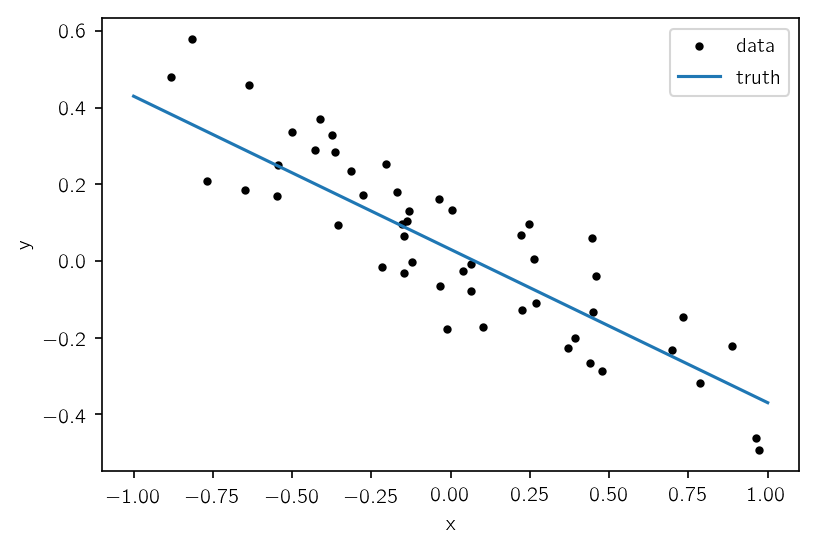

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(123)

true_params = (-0.4, 0.03, 0.1)
x = np.sort(np.random.uniform(-1, 1, 50))
y = true_params[0] * x + true_params[1] + true_params[2] * np.random.randn(len(x))

plt.plot(x, y, ".k", label="data")
t = np.linspace(-1, 1, 5000)
plt.plot(t, true_params[0]*t+true_params[1], label="truth")
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

We won't go into the mathematical details of this model here (if you're interested, check out [Hogg, Bovy, & Lang 2010](https://arxiv.org/abs/1008.4686)), but the basic idea is that we need to write down the following likelihood function for this model:

$$
\log p(y\,|\,m,\,b,\,s) = -\frac{1}{2}\,\sum_{n=1}^N \left[ \frac{(y_n - m\,x_n - b)^2}{s^2} + \log(2\,\pi\,s^2) \right]
$$

In NumPy, you might write this function as follows:

In [3]:
def np_log_like(x, y, m, b, s):
    model = m * x + b
    return -0.5*np.sum(((y-model)/s)**2+np.log(2*np.pi*s**2))

print("The log likelihood computed using numpy: {0}".format(np_log_like(x, y, *true_params)))

The log likelihood computed using numpy: 38.043974115093675


Now your job is to fill in the following function and re-write this in TensorFlow. (The docs are [here](https://www.tensorflow.org/api_docs/python/tf).)

In [4]:
import tensorflow as tf
print("Using TensorFlow version {0}".format(tf.__version__))

# The default type in tensorflow is float32, but we want to force float64 here.
T = tf.float64

# Convert the numpy arrays to tensors.
# This step of using the "constant" method isn't strictly necessary,
#  but it will come in handy later.
x_tensor = tf.constant(x, dtype=T)
y_tensor = tf.constant(y, dtype=T)

# These are the parameters that we will fit for.
# Most tensors are immutable so we need to call them "Variable"s if we
#  want to change them.
m_tensor = tf.Variable(true_params[0], dtype=T)
b_tensor = tf.Variable(true_params[1], dtype=T)
# s_tensor = tf.Variable(true_params[2], dtype=T)
# TODO: CHANGE THIS
log_s_tensor = tf.Variable(np.log(true_params[2]), dtype=T)
s_tensor = tf.exp(log_s_tensor)

# This is the function that you should write.
# Hint: in many cases you can get a long way by taking numpy code and
#  converting "np" to "tf".
def tf_log_like(x, y, m, b, s):
    # ADD YOUR CODE HERE...
    model = m * x + b
    return -0.5*tf.reduce_sum(((y-model)/s)**2+tf.log(2*np.pi*s**2))

# Now we execute this function to define the operations.
log_like = tf_log_like(x_tensor, y_tensor, m_tensor, b_tensor, s_tensor)
print("'log_like' is: {0}".format(log_like))

# And finally open a session to execute the model.
with tf.Session() as session:
    # This step is needed to set up the variables.
    session.run(tf.global_variables_initializer())
    
    # And compute the log likelihood.
    print("The log likelihood computed using tensorflow: {0}"
          .format(session.run(log_like)))

/Users/dforeman/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Using TensorFlow version 1.7.0
'log_like' is: Tensor("mul_2:0", shape=(), dtype=float64)
The log likelihood computed using tensorflow: 38.043974115093675


If the value of the log likelihood of this cell isn't identical to the one above, edit your function until it is.
After that, think a bit about what is happening at each step of the code.
What does the value of `log_like` mean and why does it have this value?

## The "feed_dict"

One useful concept in TensorFlow is called the `feed_dict` and it is passed to the `session.run` method as a keyword argument.
It allows you to easily evaluate some part of your model for different values of any number of tensors without re-defining the full graph.
For example, to compute the log likelihood for a different slope, we could use the following code:

In [5]:
feed_dict = {
    m_tensor: 0.1,  # <-- NOTE: this is *not* a typo. The key should be
                    #           *the tensor*, not a string!
}

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print("The log likelihood for a slope of 0.1: {0}"
          .format(session.run(log_like, feed_dict=feed_dict)))

The log likelihood for a slope of 0.1: -121.37882419883074


This is generally most useful for parameters that you are fitting for, but it also works for other tensors.
For example, we can compute the likelihood for a different dataset as follows:

In [6]:
feed_dict = {
    y_tensor: np.zeros_like(y),
}

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print("The log likelihood for a dataset of zeros: {0}"
          .format(session.run(log_like, feed_dict=feed_dict)))

The log likelihood for a dataset of zeros: -19.321491806784866


## Gradients & optimization

One of the key benefits of TensorFlow is that it efficiently computes gradients of scalar functions with respect to any other tensors.
These gradients can be used with many inference algorithms to improve the reliability and efficiency of fitting probabilistic models to data.
For example, many non-linear optimization algorithms (like the ones that might be familiar from [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html)) can substantially benefit from gradients of the objective function.
Furthermore, the performance of Markov chain Monte Carlo (MCMC) methods can be improved by using the gradients of the log probability function to generate samples (see [Radford Neal's review](http://www.mcmchandbook.net/HandbookChapter5.pdf), for example).

In the following cell, use the [tf.gradients](https://www.tensorflow.org/api_docs/python/tf/gradients) function to define an operation to compute the gradient of `log_like` with respect to `m_tensor`, `b_tensor`, and `s_tensor`.
Then, open a session, and evaluate this gradient (you should get something like: `[-48.6057, 52.6399, 122.76701]`).

In [7]:
# ADD YOUR CODE HERE...

grad = tf.gradients(log_like, [m_tensor, b_tensor, s_tensor])

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print(session.run(grad))

[-48.6057096067264, 52.63990461776443, 122.76707748749914]


Now that you see how to compute these gradients, go back up to the cell where we defined our model in TensorFlow and re-write it in terms of $\log(s)$ instead of $s$. (This is generally a better parameterization for any model where a parameter must always be positive.)
This should involve introducing a new `Variable` (`log_s_tensor` instead of `s_tensor`) and then redefining `s_tensor` in terms of `log_s_tensor`.
With this new parameterization, how would you compute the gradient of `log_like` with respect to the new parameters?

We can now use our model and one of the gradient based optimizers included with TensorFlow.
Specifically, let's use the interface to the optimizers in [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html) because these optimizers are commonly used by astronomers.
First, remember that (for historical reasons) most optimizers *minimize* their objective so we'll want to minimize the *negative* log likelihood in order to *maximize* the log likelihood.

In [8]:
neg_log_like = -log_like

opt = tf.contrib.opt.ScipyOptimizerInterface(
    neg_log_like, var_list=[m_tensor, b_tensor, log_s_tensor])

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    print("Initial log likelihood: {0}".format(session.run(log_like)))
    opt.minimize(session)
    print("Final log likelihood: {0}\n".format(session.run(log_like)))
    
    params = session.run([m_tensor, b_tensor, s_tensor])
    print("Final parameters: {0}".format(params))
    print("True parameters: {0}".format(true_params))

Instructions for updating:
Use the retry module or similar alternatives.
Initial log likelihood: 38.043974115093675
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: -39.825439
  Number of iterations: 10
  Number of functions evaluations: 12
Final log likelihood: 39.8254388012575

Final parameters: [-0.4451492551952392, 0.0406957941288166, 0.10910471750576961]
True parameters: (-0.4, 0.03, 0.1)


## Interfacing with Python & sampling using MCMC

Another common task is to sample the posterior probability using MCMC.
To start, we need to choose a log prior for the parameters.
For today, let's choose an improper uniform prior on `log_s_tensor` (i.e. a constant value for all values of `log_s_tensor`) and use the prior [suggested by Jake VanderPlas on his blog](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/#Prior-on-Slope-and-Intercept) for `m_tensor` and `b_tensor`.
First, write down the log prior from Jake's blog post and add it to `log_like` to get `log_prob` (a tensor that will be equal to the log posterior up to an additive constant).

In [9]:
log_prior = -1.5 * tf.log(1.0 + m_tensor**2)
log_prob = log_like + log_prior
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print(session.run(log_prob))

37.821344107416266


This worksheet comes with a helper class called `TFModel` that can be used to create a interface between a TensorFlow model and standard Python fitting packages.
The key feature of this interface is that it wraps a tensor and exposes the value and gradient as Python methods (using the `feed_dict` as described above).
For example, to wrap our log probability, we can use the following workflow:

In [10]:
# First we say that we want the model to return the value and gradient
# of `log_prob` as a function of the parameters `m_tensor`, `b_tensor`,
# and `log_s_tensor`.
from helpers import TFModel
model = TFModel(log_prob, [m_tensor, b_tensor, log_s_tensor])

with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    
    # Within the session, you first need to call the `setup` method.
    model.setup(session)
    
    # You can access the current parameter vector for the model.
    # This will always be a flat numpy array.
    params = model.current_vector()
    
    # The value and gradient of the tensor can be evaluated for specific
    # values of the parameters.
    print("The value is: {0}".format(model.value(params)))
    print("The gradient is: {0}".format(model.gradient(params)))

The value is: 37.821344107416266
The gradient is: [-47.57122685  52.63990462  12.27670775]


As an example, we can use this interface to use [emcee](http://emcee.readthedocs.io) to sample this posterior probability that we have defined.
To run this cell, you will need to install emcee (the docs are [here](http://emcee.readthedocs.io)).

In [11]:
import time
import emcee

emcee_time = time.time()
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    model.setup(session)
    
    pos = model.current_vector()
    pos = pos + 1e-5*np.random.randn(32, len(pos))
    nwalkers, ndim = pos.shape
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, model.value)
    pos, _, _ = sampler.run_mcmc(pos, 200)
    sampler.reset()
    pos, _, _ = sampler.run_mcmc(pos, 2000)
emcee_time = time.time() - emcee_time

And then we can plot the results using the [corner](http://corner.readthedocs.io/) package.

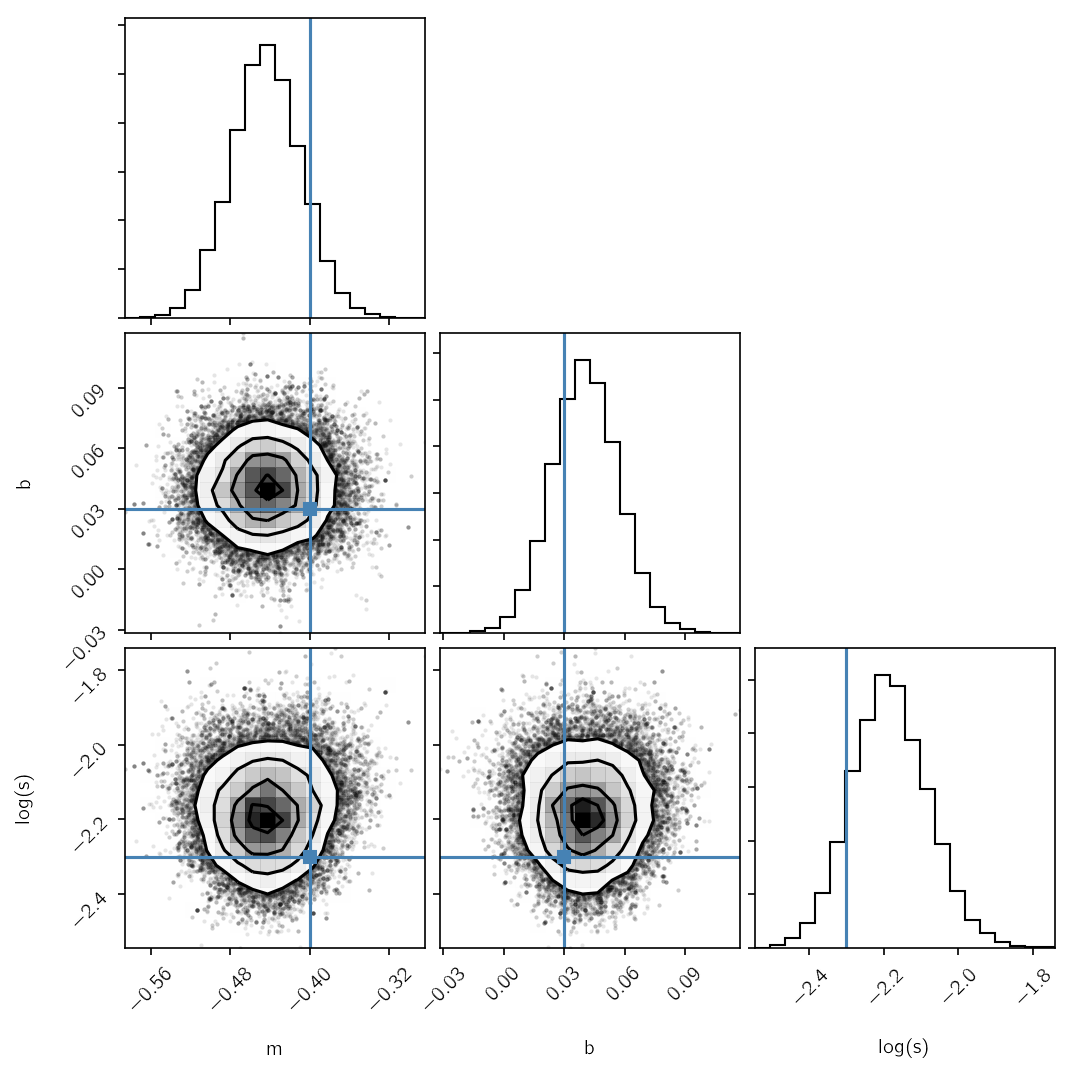

In [12]:
import corner
truth = np.array(true_params)
truth[-1] = np.log(true_params[-1])
corner.corner(sampler.flatchain,
              labels=["m", "b", "log(s)"],
              truths=truth);

## Hamiltonian Monte Carlo (HMC)

This looks pretty good, but emcee doesn't currently have support for methods like HMC that use gradient information to improve the efficiency of the inference.
While there are several packages that exist in Python for running HMC, I haven't been completely happy with any of them so, for this tutorial, I wrote a simple Hamiltonian sampler (specifically it implements the [No U-Turns Sampler](https://arxiv.org/abs/1111.4246) as implemented in [Stan](http://mc-stan.org/) and [PyMC3](http://docs.pymc.io/)).
This isn't the place to get into the details of a sampler like this, but to run it here, you can use the following code:

In [17]:
import helpers

# We will cheat a little bit and use our previous chain to estimate the
# the appropriate tuning scales for the parameters.
metric = helpers.DiagonalMetric(3, np.var(sampler.flatchain, axis=0))

nuts_time = time.time()
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    model.setup(session)  # <-- Don't forget to run setup!

    # This method does the sampling:
    nuts = helpers.tf_simple_nuts(
        session,
        log_prob,
        [m_tensor, b_tensor, log_s_tensor],
        3500,          # The number of MCMC steps
        1.0,           # The integration step size
        metric=metric  # The scaling metric computed above
    )
nuts_time = time.time() - nuts_time

100%|██████████| 3500/3500 [00:09<00:00, 365.52it/s]


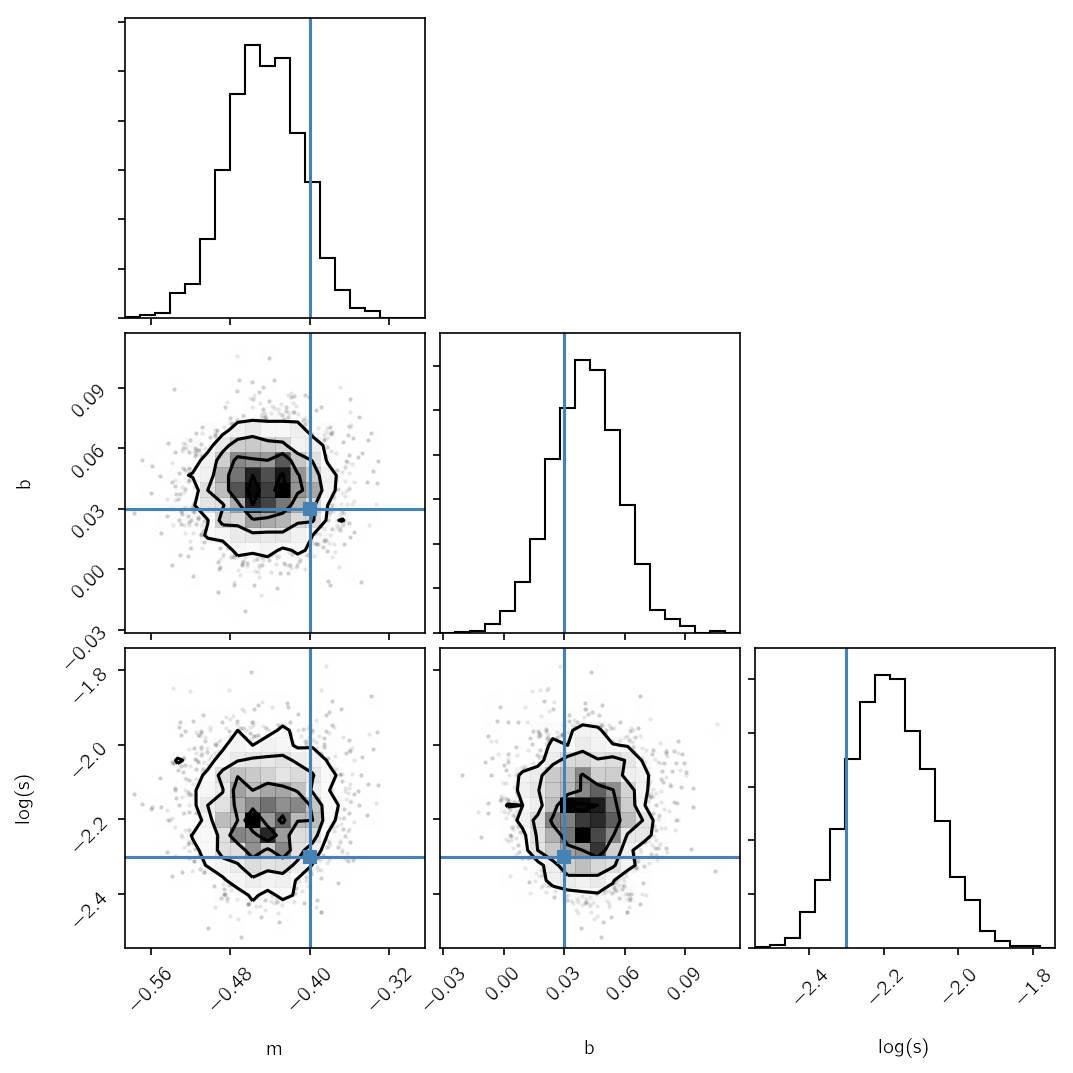

In [18]:
corner.corner(nuts[0],
              range=[(np.min(v), np.max(v)) for v in sampler.flatchain.T],
              labels=["m", "b", "log(s)"],
              truths=truth);

These contours look a little bit rattier than the ones above, but the real test is the computation time per *independent* sample (see [this blog post](http://dfm.io/posts/autocorr/) for a discussion of methods for estimating the number of independent samples).
For this example, we can compute the number of independent samples from each chain:

In [22]:
# First estimate the autocorrelation time of each chain
from autocorr import integrated_time
tau_emcee = integrated_time(np.swapaxes(sampler.chain, 0, 1))
tau_nuts = integrated_time(nuts[0][:, None, :])

# Then the effective numbers of samples
neff_emcee = len(sampler.flatchain) / np.mean(tau_emcee)
neff_nuts = len(nuts[0]) / np.mean(tau_nuts)

print("The effective number of samples from emcee: {0:.0f}".format(neff_emcee))
print("The effective number of samples from NUTS: {0:.0f}".format(neff_nuts))
print("The time per effective sample for emcee: {0:.1f} ms".format(1000*emcee_time / neff_emcee))
print("The time per effective sample for NUTS: {0:.1f} ms".format(1000*nuts_time / neff_nuts))

The effective number of samples from emcee: 1928
The effective number of samples from NUTS: 2777
The time per effective sample for emcee: 9.2 ms
The time per effective sample for NUTS: 3.5 ms


If everything went as planned, you should see that the NUTS sampler is substantially more efficient (i.e. it requires less computation time per independent sample) than emcee (but we're not considering the cost of tuning here).
This disparity will tend to increase for problems with more parameters.
In general, sampling a density with tens of parameters using emcee will require substantially more patience and computation power than sampling the same problem with NUTS, but NUTS is more sensitive to the specific choices of tuning parameters. 